###  Car Price Modeling Project

* Part 1 - Predict price with car metadata

* Part 2 - Predict price with metadata + image

* Details:  Get metadata from craigslist API.  Get additional relevant features, like gas price.  
  Clean data.  Put clean data in SQLite database.

### `Research Notes`

In [1]:
#KEY FEATURES
#price label, brand, model, age, horsepower/engine_type, mileage. time passage from ad post?

#SECONDARY FEATURES
#make, fuel type, mpg, exterior color, door number, transmission type,
#dimensions, safety, air condition, interior, navigation y/n, engine type
#cubic capacity, number of ad views, power steering, rim type
#registered city, number of doors, 4WD, damaged, leather, alarm,
#A/C, parking sensors, xenon lights, remote unlock, electric mirrors,
#seat heat, moon roof, cruise control, abs, traction control

#OTHER FEATURES
#estimated car life, price rank as category (cheap, moderate, expensive)

#Non-craigslist features
# gas price

#Sparse features to ignore?: damaged, city

In [2]:
#FEATURE ENHANCEMENT:
#Train with stratified sample of make
#Encode Thumbs Up/Down fields: [ON, OFF, NotAvailable] -> [1, -1, 0]
#Poly features for regression.  Ex. Mileage and year
#Differencing features and explicit features for orest.

In [3]:
# Candidate models
# Regression, KNN, SVM, random forest, naive bayes, neural networks
# Neural network should be best, followed by RF and SVM.

In [4]:
# Frame as Price as Regression vs Classification Problem
# Classification: bin continuous features using cluster analysis?

###  Imports

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Python iterators for efficient looping
import itertools

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

#Distributions
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

#Model selection
from sklearn.model_selection import RandomizedSearchCV

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
%pwd

'C:\\Users\\Justin\\DATA_SCIENCE\\car_price_prediction'

In [7]:
#Import data - austin, dallas, houston, and san antonio.  Pulled 11-13-2019 around 10am.
austin=pd.read_json('austin_ford.json')
dallas=pd.read_json('dallas_ford.json')
houston=pd.read_json('houston_ford.json')
sa=pd.read_json('sanantonio_ford.json')

print('Combined len:', len(austin) + len(dallas) + len(houston) + len(sa))

Combined len: 9988


In [8]:
vehicle = pd.DataFrame()
for dframe in [austin, dallas, houston, sa]:
    vehicle = vehicle.append(dframe, ignore_index = True)
display('vehicle:', vehicle.tail(1))

'vehicle:'

,URL_Vehicle,Title,Price,SubLoc,AttribDictionary,ImageDictionary
9987,https://sanantonio.craigslist.org/ctd/d/san-an...,****2013 FORD FOCUS SE 2.0L****BLUETOOTH**USB/...,$7500,(San Antonio),{'0': '<span><b>2013 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00p0p_8Yx...


In [9]:
#Remove whitespace
vehicle['SubLoc'] = vehicle['SubLoc'].str.strip()

In [10]:
#TRUCKMAX autos are outside Texas.  Drop them.
vehicle[vehicle['SubLoc'] == '(TRUCKMAX)']
drop_indices = vehicle[vehicle['SubLoc'] == '(TRUCKMAX)'].index
print(f'Drop {len(drop_indices)} TRUCKMAX listings outside Texas:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 182 TRUCKMAX listings outside Texas: Int64Index([1684, 1685, 1862, 1863, 1888, 1889, 2161, 2162, 2259, 2260,
            ...
            9448, 9457, 9461, 9492, 9541, 9557, 9612, 9741, 9817, 9833],
           dtype='int64', length=182)


In [11]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

In [12]:
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

def train_and_valid(what_model, num_folds, X, y):
    fold_rsme=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns

        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_rsme.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 3))
    return fold_rsme, clone_model

In [13]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))
vehicle.insert(2,'Location',np.nan)
vehicle.insert(3,'Year',np.nan)
vehicle.insert(4,'Year_in_Title',np.nan)
vehicle.insert(5,'Odometer',np.nan)
vehicle.insert(6,'RawMake',np.nan)
vehicle.insert(7,'Make',np.nan)
vehicle.insert(8,'Model',np.nan)
vehicle.insert(9,'Trim',np.nan)
vehicle.insert(10,'Seller',np.nan)
vehicle.head(2)

vehicle length: 9806
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,AttribDictionary,ImageDictionary
0,https://austin.craigslist.org/ctd/d/2017-ford-...,"""2017 FORD FOCUS"" WE FINANCE, $1,000 TODAY DIV...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,"{'0': '<span><b>2017 FORD FOCUS</b></span>', '...",{'0': 'https://images.craigslist.org/00m0m_e8O...
1,https://austin.craigslist.org/ctd/d/round-rock...,2008 Ford Fusion SE 113K Miles Clean CarFax,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$3977,(Remarkable Motors),"{'0': '<span><b>2008 Ford Fusion</b></span>', ...",{'0': 'https://images.craigslist.org/00t0t_79t...


In [14]:
#Extract vehicle location from URL location.craigslist.org
rawLocList=[]
for idx in vehicle.index:
    m = re.search('https://(.+)\.craigslist', vehicle.loc[idx, 'URL_Vehicle']) #re.search(pattern, string) gets first match
    if m is not None:
        rawLocList.append(m.group(1).lower())
    else:
        print('Missing Make/Model index:', idx)
        rawLocList.append('None')
                 
vehicle['Location'] = rawLocList

In [15]:
vehicle.loc[0, 'AttribDictionary']

{'0': '<span><b>2017 FORD FOCUS</b></span>',
 '1': '<span>condition: <b>like new</b></span>',
 '2': '<span>cylinders: <b>4 cylinders</b></span>',
 '3': '<span>drive: <b>fwd</b></span>',
 '4': '<span>fuel: <b>gas</b></span>',
 '5': '<span>size: <b>mid-size</b></span>',
 '6': '<span>title status: <b>clean</b></span>',
 '7': '<span>transmission: <b>automatic</b></span>'}

In [16]:
#Extract any Odometer from AttribDictionary.  For each index, go through dict keys.
odomet=[]
for idx in vehicle.index:
    success_flag = 0    
    for k in vehicle.loc[idx, 'AttribDictionary'].keys():
        m = re.search('<span>odometer: <b>(\d+)', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match    
        
        if m is not None:
            success_flag = 1
            odomet.append(m.group(1))
            
    if success_flag != 1:
        odomet.append(np.nan)

vehicle['Odometer'] = odomet
vehicle['Odometer'] = vehicle['Odometer'].astype('float')

In [17]:
#Drop Odometer values of zero bc autos are used.

odZeroFilt = (vehicle['Odometer'] == 0)
drop_indices = vehicle[odZeroFilt].index
print(f'Drop {len(drop_indices)} Odometer is zero miles:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 43 Odometer is zero miles: Int64Index([  15,   78,   80,  117,  151,  218,  220,  449,  913,  974, 1256,
            1319, 1321, 1485, 1553, 1554, 1555, 1602, 1652, 1653, 1654, 1933,
            2071, 2380, 3277, 3329, 3760, 3803, 4301, 4421, 4990, 5079, 5142,
            5802, 6007, 6266, 6579, 7075, 7141, 7344, 7870, 8959, 9693],
           dtype='int64')


In [18]:
#Create dealer/owner features using URL_vehicle.
vehicle['Seller']=vehicle['URL_Vehicle'].str.extract('(ct[o|d])')
vehicle['Seller']=vehicle['Seller'].str.replace('ctd', 'dealer')
vehicle['Seller']=vehicle['Seller'].str.replace('cto', 'owner')

In [19]:
#Build Year column from AttribDictionary.  Assert numeric format and none missing.
yrList=[]
for idx in vehicle.index:
    m = re.search('(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  #group(1) returns first parenthesized subgroup
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

#Keep Years 1999 and later.
filt = (vehicle['Year'] >= 1999)
vehicle = vehicle[filt]

assert vehicle['Year'].dtypes == 'int64',  "Year must be integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

In [20]:
#Extract RawMake col from AttribDictionary.

rawMakeList=[]
for idx in vehicle.index:
    m = re.search('<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1).lower())
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [21]:
#Parse RawMake on whitespace
parsedLOL=[]
for idx in vehicle.index:
    rwMake = vehicle.loc[idx, 'RawMake']
    rwMake.split()
    parsedLOL.append(rwMake.split())  #runs of consecutive whitespace are treated as a single separator

#Populate Make, Model, and Trim.
for row in parsedLOL:
    if len(row) < 6:
        row.append('None')
        row.append('None')
        row.append('None')
        row.append('None')
    if row[0] == row[1]:  #duplicate year scenario
        row[1] = row[2]
        row[2] = row[3]
        row[3] = row[4]
    if row[2] == 'super' and row[3] == 'duty':  #trim before model scenario
        row[2] = row[4] 
        row[3] = 'super'     #assign trim to super
    if row[3] == 'el':  #clarify el xlt, el king, el platinum
        row[3] = row[4]       
        
vehicle['Make']=[item[1] for item in parsedLOL]
vehicle['Model']=[item[2] for item in parsedLOL]
vehicle['Trim']=[item[3].split(',')[0] for item in parsedLOL]

In [22]:
pd.set_option('max_colwidth', 100)
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,AttribDictionary,ImageDictionary
0,https://austin.craigslist.org/ctd/d/2017-ford-focus-we-finance-1000-today/7019224961.html,"""2017 FORD FOCUS"" WE FINANCE, $1,000 TODAY DIVE TODAY",austin,2017,NaN,NaN,2017 ford focus,ford,focus,None,dealer,None,None,"{'0': '<span><b>2017 FORD FOCUS</b></span>', '1': '<span>condition: <b>like new</b></span>', '2'...","{'0': 'https://images.craigslist.org/00m0m_e8OdwBcIwee_600x450.jpg', '1': 'https://images.craigs..."
1,https://austin.craigslist.org/ctd/d/round-rock-2008-ford-fusion-se-113k/7018933559.html,2008 Ford Fusion SE 113K Miles Clean CarFax,austin,2008,NaN,NaN,2008 ford fusion,ford,fusion,None,dealer,$3977,(Remarkable Motors),"{'0': '<span><b>2008 Ford Fusion</b></span>', '1': '<span>condition: <b>good</b></span>', '2': '...","{'0': 'https://images.craigslist.org/00t0t_79tmoKPwmNV_600x450.jpg', '1': 'https://images.craigs..."


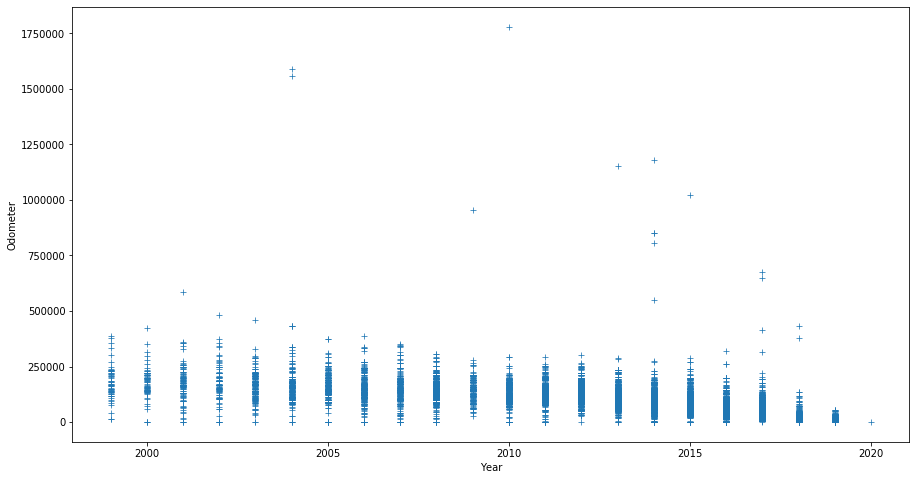

In [23]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='Year',y='Odometer', data=vehicle,  marker= '+')
plt.show()

In [24]:
# #Drop Make = 'None'
# filt = (vehicle['Make'] == 'None')
# drop_indices = vehicle[filt].index
# print('Drop Make is None rows:', drop_indices)
# vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

In [25]:
#Scrub Price - remove any $, periods, and spaces.  Note:  ORDER IS IMPORTANT!!!
vehicle['Price']=vehicle['Price'].str.replace('\,', '')
vehicle['Price']=vehicle['Price'].str.replace('\.00', '')
vehicle['Price']=vehicle['Price'].str.replace('\.0', '')
vehicle['Price']=vehicle['Price'].str.replace('\$', '')
vehicle['Price']=vehicle['Price'].str.replace('-', '')
vehicle['Price']=vehicle['Price'].str.replace(' ', '')
vehicle['Price']=vehicle['Price'].str.replace('\.', 'None')

In [26]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,AttribDictionary,ImageDictionary
0,https://austin.craigslist.org/ctd/d/2017-ford-focus-we-finance-1000-today/7019224961.html,"""2017 FORD FOCUS"" WE FINANCE, $1,000 TODAY DIVE TODAY",austin,2017,NaN,NaN,2017 ford focus,ford,focus,None,dealer,None,None,"{'0': '<span><b>2017 FORD FOCUS</b></span>', '1': '<span>condition: <b>like new</b></span>', '2'...","{'0': 'https://images.craigslist.org/00m0m_e8OdwBcIwee_600x450.jpg', '1': 'https://images.craigs..."
1,https://austin.craigslist.org/ctd/d/round-rock-2008-ford-fusion-se-113k/7018933559.html,2008 Ford Fusion SE 113K Miles Clean CarFax,austin,2008,NaN,NaN,2008 ford fusion,ford,fusion,None,dealer,3977,(Remarkable Motors),"{'0': '<span><b>2008 Ford Fusion</b></span>', '1': '<span>condition: <b>good</b></span>', '2': '...","{'0': 'https://images.craigslist.org/00t0t_79tmoKPwmNV_600x450.jpg', '1': 'https://images.craigs..."


In [27]:
#Price is missing, None, or blank.  Drop corresponding rows.
filt = (vehicle['Price'].isna()) | (vehicle['Price'] == 'None') | (vehicle['Price'] == '')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} missing price rows:', drop_indices, '\n')
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Make isn't 'ford'.  Drop corresponding rows.
filt = (vehicle['Make'] != 'ford')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} non-ford makes:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Cast Price as float.
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

Drop 1082 missing price rows: Int64Index([   0,   29,   44,   61,   81,   82,   83,   85,  120,  131,
            ...
            9920, 9921, 9928, 9938, 9946, 9951, 9960, 9961, 9965, 9985],
           dtype='int64', length=1082) 

Drop 54 non-ford makes: Int64Index([ 901, 1084, 1128, 1156, 1710, 1814, 1828, 1960, 1962, 2481, 2482,
            2511, 2513, 2680, 2761, 2762, 2832, 2999, 3148, 3153, 3193, 3222,
            3767, 3834, 3835, 3860, 4334, 4335, 4343, 4346, 4359, 4801, 4919,
            5138, 5223, 5991, 6718, 7688, 7699, 7702, 7955, 8041, 8080, 8090,
            8153, 8208, 9166, 9583, 9585, 9683, 9838, 9847, 9849, 9852],
           dtype='int64')


In [28]:
#Fix Model names.
model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'f150' : 'f-150',
                      'f250' : 'f-250', 
                      'f350' : 'f-350', 
                      'f450' : 'f-450'}
            }

vehicle.replace(model_dict, inplace=True)

#Fix Trim names.  LGB  and Ridge do best with NaN fix only.  Worse with spelling correction.
#And still worse with spelling and None corrections.
trim_dict={'Trim': {np.nan : 'None'}}

# trim_dict = {'Trim': {np.nan: 'None',
#                       'crewcab': 'crew',
#                       'deisel': 'diesel',
#                       'e150': 'e-150',
#                       'e250': 'e-250',
#                       'e350': 'e-350',
#                       'e450': 'e-450',
#                       'gasolina': 'super',
#                       'harley-': 'harley',
#                       'harley-davidson': 'harley',
#                       'kingranch4x4crewdiesel': 'king',
#                       'sd': 'super',
#                       'súper': 'super',
#                       'superduty': 'super',
#                       'svt': 'raptor',
#                       'sxt': 'stx',
#                       't250': 't-250',
#                       'tit': 'titanium'}}

# trim_dict={
#             'Trim': {np.nan : 'None',
#                      '4.6l' : 'None',
#                      '5' : 'None',
#                      '5.4' : 'None',
#                      '7.3l' : 'None',
#                      '12' : 'None',
#                      '15' : 'None',
#                      '16' : 'None',    
#                      '7.3' : 'None',
#                      '150' : 'None',
#                      '250' : 'None',
#                      '2007' : 'None',
#                      '2011' : 'None',
#                      '2013' : 'None',
#                      '2015' : 'None',
#                      '2016' : 'None',
#                      '1-owner' : 'None',
#                      '2wd' : 'None',
#                      '4dr' : 'None',
#                      '4wd' : 'None',
#                      '6.7l' : 'None',
#                      'crewcab' : 'crew',
#                      'deisel' : 'diesel',
#                      'e150' : 'e-150',
#                      'e250' : 'e-250',
#                      'e350' : 'e-350',
#                      'e450' : 'e-450',                 
#                      'f' : 'None',
#                      'f250' : 'None',
#                      'f350' : 'None',
#                      'f450' : 'None',
#                      'f550' : 'None',
#                      'gasolina' : 'super',
#                      'harley-' : 'harley',
#                      'harley-davidson' : 'harley',
#                      'kingranch4x4crewdiesel' : 'king',
#                      'ltd' : 'None',
#                      'pickup' : 'None',
#                      'powerstroke' : 'None',
#                      'reg' : 'None',
#                      'regular' : 'None',
#                      'sd' : 'super',
#                      'ses' : 'se',
#                      'sh' : 'None',
#                      'súper' : 'super',                     
#                      'superduty' : 'super',
#                      'suv' : 'None',                   
#                      'svt' : 'raptor',
#                      'sxt' : 'stx',
#                      't250' : 't-250',
#                      'tit' : 'titanium',
#                      'v6' : 'None',
#                      'van' : 'None',
#                      'x' : 'None',                 
#                      }
#             }

vehicle.replace(trim_dict, inplace=True)

#Remove vehicle 'Model' counts under 50.  Save to dataframe veh.
model_counts=vehicle['Model'].value_counts()             #get model freq
models_over_50 = model_counts[model_counts >= 50].index  #get 50+ model names
vehicle= vehicle[vehicle['Model'].isin(models_over_50)] #boolean filter for the 50+ model names
vehicle['Model'].value_counts()

f-150         1940
f-250         1178
f-350          665
mustang        663
explorer       409
escape         398
fusion         378
focus          371
expedition     352
edge           235
transit        222
taurus         131
fiesta         116
f-450          111
None            82
ranger          76
e350            74
f-550           68
econoline       58
excursion       54
Name: Model, dtype: int64

In [29]:
#Drop prices under $2,201 or over $60,000.  Prices under $1,001 are usual down payments.
drop_indices=vehicle[(vehicle['Price'] < 2201) | (vehicle['Price'] > 60000)].index

print(f'Drop {len(drop_indices)} prices ouside $100 - $60,000:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 591 prices ouside $100 - $60,000: Int64Index([  31,   32,   47,   71,  104,  112,  133,  137,  181,  187,
            ...
            9855, 9858, 9859, 9873, 9875, 9876, 9956, 9964, 9976, 9977],
           dtype='int64', length=591)


In [30]:
#Drop bad prices.
bad_price_indices = vehicle[vehicle['RawMake'] == '2017 ford mustang 5.0'].index
vehicle.drop(index = bad_price_indices, inplace = True, errors = 'ignore')

In [31]:
vehicle.Trim.value_counts()

None                      4108
super                      657
xlt                        250
se                         248
gt                         106
supercrew                  105
limited                     99
lariat                      97
connect                     82
sel                         81
titanium                    72
king                        69
cargo                       61
4x4                         55
fx4                         53
xl                          49
sport                       44
f350                        39
platinum                    36
eddie                       35
hybrid                      33
s                           30
f550                        29
sd                          28
crew                        25
fx2                         22
diesel                      20
f450                        19
ecoboost                    18
convertible                 18
st                          17
v6                          16
passenge

In [32]:
#Flag outliers at designated year.
def flag_outliers(df, filt_col, filt_col_val, col_to_flag):
    ''' Flag anomolies for target col_to_flag and filt_col_val.'''
    filtSer=df.loc[df[filt_col] == filt_col_val, col_to_flag].copy()
    three_std = 3 * filtSer.std()
    avg = filtSer.mean()
    lower_lim = avg - three_std
    upper_lim = avg + three_std
    print(' average:', round(avg,1), '\n', 'lower_lim:', round(lower_lim,1), '\n', 'upper_lim:', round(upper_lim,1))
    
    outside_lim=[]
    for idx in filtSer.index:      
        price = filtSer.loc[idx]        
        if price > upper_lim or price < lower_lim:
            outside_lim.append([idx, col_to_flag, price])     
    return outside_lim

outs_lim = flag_outliers(df=vehicle, filt_col='Year', filt_col_val=2002, col_to_flag='Odometer')               
display(outs_lim)

 average: 179656.8 
 lower_lim: -44541.6 
 upper_lim: 403855.3


[]

In [33]:
# pd.set_option('max_colwidth', 100)
# veh.loc[1472]

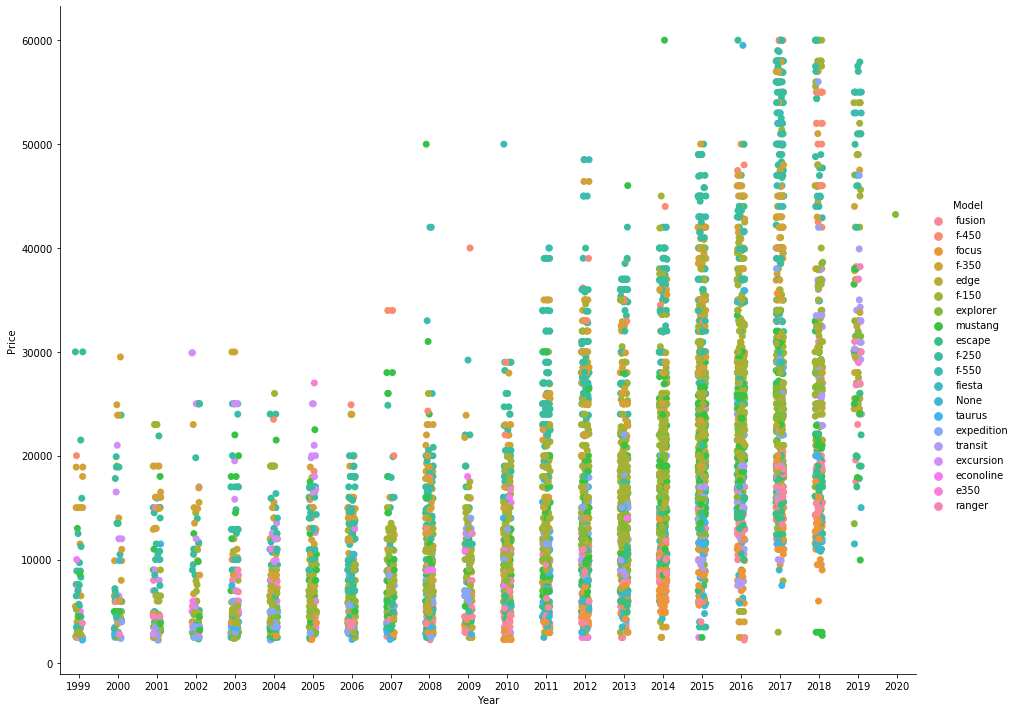

In [34]:
#Catplot by Year, Price, and Model
sns.catplot(x='Year',y='Price',hue='Model', data=vehicle, height=10, aspect=1.3, s=7)  #s changes marker size
plt.show()

In [35]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,AttribDictionary,ImageDictionary
1,https://austin.craigslist.org/ctd/d/round-rock-2008-ford-fusion-se-113k/7018933559.html,2008 Ford Fusion SE 113K Miles Clean CarFax,austin,2008,NaN,NaN,2008 ford fusion,ford,fusion,None,dealer,3977.0,(Remarkable Motors),"{'0': '<span><b>2008 Ford Fusion</b></span>', '1': '<span>condition: <b>good</b></span>', '2': '...","{'0': 'https://images.craigslist.org/00t0t_79tmoKPwmNV_600x450.jpg', '1': 'https://images.craigs..."
2,https://austin.craigslist.org/cto/d/wellborn-ford-f450-king-ranch-4x4-dually/7018955492.html,Ford F450 King Ranch 4x4 Dually,austin,2013,NaN,100756.0,2013 ford f450 4x4,ford,f-450,4x4,owner,35000.0,(College Station),"{'0': '<span><b>2013 ford f450 4x4</b></span>', '1': '<span>VIN: <b>1FT8W4DT8DEA54846</b></span>...","{'0': 'https://images.craigslist.org/00707_24nkDUYeEOD_600x450.jpg', '1': 'https://images.craigs..."


In [36]:
#Engineer vehicle features Part 1.  Get category feature pairs - no repeats.

cat_feat=['Model', 'Trim', 'Seller']
pairs = list(itertools.combinations(cat_feat,2))
for tup in pairs:
        vehicle[tup[0] + '_' + tup[1]] = vehicle[tup[0]] + '_' + vehicle[tup[1]]

In [37]:
vehicle.head(1)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,AttribDictionary,ImageDictionary,Model_Trim,Model_Seller,Trim_Seller
1,https://austin.craigslist.org/ctd/d/round-rock-2008-ford-fusion-se-113k/7018933559.html,2008 Ford Fusion SE 113K Miles Clean CarFax,austin,2008,NaN,NaN,2008 ford fusion,ford,fusion,None,dealer,3977.0,(Remarkable Motors),"{'0': '<span><b>2008 Ford Fusion</b></span>', '1': '<span>condition: <b>good</b></span>', '2': '...","{'0': 'https://images.craigslist.org/00t0t_79tmoKPwmNV_600x450.jpg', '1': 'https://images.craigs...",fusion_None,fusion_dealer,None_dealer


In [38]:
vehicle.to_csv('temp.csv')

## Get train and test, stratified by Model.

In [39]:
#Build train and test from vehicle.  Stratify by Model.
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=22)
for train_index, test_index in sss.split(vehicle, vehicle['Model']):
    train = vehicle.iloc[train_index]
    test = vehicle.iloc[test_index]

In [40]:
#Drop features
train = train.drop(['URL_Vehicle', 'Title', 'Year_in_Title', 'LN_Price', 'SubLoc', 'AttribDictionary', 'ImageDictionary', 'RawMake'],
           axis='columns', errors='ignore')

test = test.drop(['URL_Vehicle', 'Title', 'Year_in_Title', 'LN_Price', 'SubLoc', 'AttribDictionary', 'ImageDictionary', 'RawMake'],
           axis='columns', errors='ignore')

In [41]:
def impute_nan_by_categ(train_df, test_df, cat_col1, cat_col2, stat_col, stat_calc = 'median'):
    ''' Using train, get dictionary entry for each cat_col 1-2 group:
        {'group': {'stat_col': value}}.  Replace nan with train value in 
        both train and test.  This avoids data leakage.  Return  updated
        train and test dataframes.'''
    
    trn = train_df.copy()
    tst = test_df.copy()
    trnDict=trn.groupby([cat_col1, cat_col2]).agg({stat_col : stat_calc}).to_dict('index')
    trnDict_fallback=trn.groupby([cat_col1]).agg({stat_col : stat_calc}).to_dict('index')
    print(f'Made dictionary of {stat_calc} {stat_col} value by {cat_col1}-{cat_col2}. Fallback by {cat_col1}.')
        
    for k in trnDict.keys():  #scrub by Model-Year
        filtTrain = (trn[cat_col1] == k[0]) & (trn[cat_col2] == k[1]) & (trn[stat_col].isna())
        filtTest = (tst[cat_col1] == k[0]) & (tst[cat_col1] == k[1]) & (tst[stat_col].isna())
        val = trnDict[k][stat_col]        
        fallback_val = trnDict_fallback[k[0]][stat_col]
        
        if np.isnan(val):
            trn.loc[filtTrain, stat_col] = fallback_val
            tst.loc[filtTest, stat_col] = fallback_val
        else:
            trn.loc[filtTrain, stat_col] = val
            tst.loc[filtTest, stat_col] = val            
            
    for key in trnDict_fallback.keys():    #scrub the missed Model-Year combos in test with Model-only fallback.
        filtTestCatCol1 = (tst[cat_col1] == key) & (tst[stat_col].isna())
        catCol1_val = trnDict_fallback[key][stat_col]
        tst.loc[filtTestCatCol1, stat_col] = catCol1_val
        
    return trn, tst, trnDict, trnDict_fallback

#Update NaNs with median odometer value by Model-Year.
train, test, trnDict, trnDict_fallback = impute_nan_by_categ(train_df=train, test_df=test, cat_col1='Model', cat_col2='Year', stat_col='Odometer')  

Made dictionary of median Odometer value by Model-Year. Fallback by Model.


In [42]:
#Correct odometer values that are thousands - train and test
filt_under_1K = train['Odometer'] < 1000
train.loc[filt_under_1K, 'Odometer'] = train.loc[filt_under_1K, 'Odometer'] * 1000

filt_under_1K = test['Odometer'] < 1000
test.loc[filt_under_1K, 'Odometer'] = test.loc[filt_under_1K, 'Odometer'] * 1000

In [43]:
#Engineer features Part 2
def get_polyfeatures(train, target, numer_cols, degree=5):
    '''
    Returns top feature correlations as DataFrame.
    '''
    from sklearn.preprocessing import PolynomialFeatures
    poly=PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)    
    ptrn = train[numer_cols].copy()
    orig_cols = set(ptrn.columns.values)
    ptrn=pd.DataFrame(data=poly.fit_transform(ptrn),index=train.index,columns=poly.get_feature_names(input_features=numer_cols))
    final_cols = set(ptrn.columns.values)
    added_cols = final_cols - orig_cols
    print('columns added:', added_cols, '\n')
            
    #Get top correlation dataframe and top features list. 
    corrList = [[c, np.corrcoef(ptrn[c].values, train[target].values)[1,0]] for c in ptrn.columns]
    corrtrn=pd.DataFrame(data=corrList, columns=['feature','PriceCorr']).sort_values(by='PriceCorr', ascending=False).dropna().reset_index(drop=True)
    print(corrtrn)
    return ptrn[added_cols]  

num_feat=[col for col in train.select_dtypes(exclude='object').columns];
num_feat.remove('Price');

#Get poly feature dataframe.
p_added = get_polyfeatures(train=train, target='Price', numer_cols=num_feat, degree=2)

#Add poly features to train and test
train['Year^2'] = train['Year']**2
train['Year_Odometer'] = train['Year'] * train['Odometer']
train['Odometer^2'] = train['Odometer']**2

test['Year^2'] = test['Year']**2
test['Year_Odometer'] = test['Year'] * test['Odometer']
test['Odometer^2'] = test['Odometer']**2

columns added: {'Odometer^2', 'Year^2', 'Year Odometer'} 

         feature  PriceCorr
0         Year^2   0.564496
1           Year   0.564206
2     Odometer^2  -0.094922
3  Year Odometer  -0.332856
4       Odometer  -0.334136


In [44]:
# #Dropping Year improves lgb prediction.
# train = train.drop(columns='Year', axis='columns', errors='ignore')
# test = test.drop(columns='Year', axis='columns', errors='ignore')

In [45]:
#Create numeric version of train for pairplotting.
train2=train.copy()
print(train2.dtypes)
display(train2.head(2))

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

for col in train2.select_dtypes('object').columns.values:  #Encode categoricals as ordinal
    train2[col] = le.fit_transform(train2[col].tolist())
display(train2.head(3))

Location          object
Year               int64
Odometer         float64
Make              object
Model             object
Trim              object
Seller            object
Price            float64
Model_Trim        object
Model_Seller      object
Trim_Seller       object
Year^2             int64
Year_Odometer    float64
Odometer^2       float64
dtype: object


,Location,Year,Odometer,Make,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,Odometer^2
2354,dallas,2017,53035.0,ford,expedition,None,dealer,38000.0,expedition_None,expedition_dealer,None_dealer,4068289,106971595.0,2.812711e+09
1840,dallas,2011,32200.0,ford,transit,None,owner,12500.0,transit_None,transit_owner,None_owner,4044121,64754200.0,1.036840e+09


,Location,Year,Odometer,Make,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,Odometer^2
2354,1,2017,53035.0,0,6,20,0,38000.0,53,12,25,4068289,106971595.0,2.812711e+09
1840,1,2011,32200.0,0,19,20,1,12500.0,240,39,26,4044121,64754200.0,1.036840e+09
3935,1,2004,178348.0,0,9,20,0,10998.0,106,18,25,4016016,357409392.0,3.180801e+10


In [46]:
#train2 correlations
train2Corr = [[c, np.corrcoef(train2[c].values, train2['Price'].values)[1,0]] for c in train2.columns]
train2Corr

C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[['Location', 0.002909485200186747],
 ['Year', 0.5642059784630583],
 ['Odometer', -0.33413594035458033],
 ['Make', nan],
 ['Model', -0.03420722341628192],
 ['Trim', -0.01004908449802594],
 ['Seller', -0.3051883652776573],
 ['Price', 1.0],
 ['Model_Trim', -0.010242296283489364],
 ['Model_Seller', -0.04959787129254427],
 ['Trim_Seller', -0.011788344244769435],
 ['Year^2', 0.5644961140767094],
 ['Year_Odometer', -0.33285555650914306],
 ['Odometer^2', -0.0949222077739132]]

In [47]:
#Investigate outliers revealed in pairplot.
# sns.set(font_scale=1.5)
# sns.pairplot(train2)
# plt.show()

### Create trainX, trainY, testX, testY

In [48]:
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

In [49]:
#train.to_csv('temp.csv')

In [50]:
#LightGBM model: Encode train/test categories as integers.  https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html#lightgbm.train

def encode_cat_to_int(train, test):
    cat_train = train.select_dtypes(['object'])
    if len(cat_train.columns) == 0:
        print('### No categorical features to encode. ###')
        return  #Dont overwrite train and test
    for c in cat_train.columns:
        le=LabelEncoder()
        #Fit encoder on all possible categories in train & test
        le.fit(train[c].values.tolist() + test[c].values.tolist())
        #Return encoding to column in train and column in test.
        train[c]=le.transform(train[c].values.tolist())
        test[c]=le.transform(test[c].values.tolist())
    return train, test

#encode_cat_to_int overwrites the passed DataFrame -- use DataFrame copy instead.
trainX_lenc, testX_lenc = encode_cat_to_int(train=trainX.copy(), test=testX.copy())    

### LightGBM with integer encoding of categories

In [51]:
#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective='regression',
                         n_jobs=1, 
                         silent=1)

# Do KFold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# RandomizedSearchCV using StratifiedKFold cross-validation
param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,150),
            "num_leaves": randint(2, 600), 
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfitting
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),
            "feature_fraction": uniform(0.01, 0.99),
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Report results for random_search.  Changed scoring from 
rs_cv = RandomizedSearchCV(clf, param_distributions=param_grid,\
                                   n_iter=40, n_jobs=-1, cv=kfold, scoring='r2',\
                                   iid=False, return_train_score=False,random_state=42)

#RUN model.  Must fix accented super non-ascii issue.
rs_cv.fit(trainX_lenc, trainY)

#SCORE model.
best_score = rs_cv.best_score_
best_score_std = rs_cv.cv_results_['std_test_score'][rs_cv.best_index_]
best_params = rs_cv.best_params_
print(f'## Grid iters checked: {len(rs_cv.cv_results_["params"])}')
print(f'## best CV score: {best_score:.4f} +- {best_score_std:.4f}\n')
print('## Best parameters:')
pprint.pprint(best_params)

## Grid iters checked: 40
## best CV score: 0.8540 +- 0.0170

## Best parameters:
{'bagging_fraction': array([0.0627198]),
 'feature_fraction': 0.940827939010708,
 'lambda_l1': array([0.0001511]),
 'lambda_l2': array([4.5502904e-05]),
 'learning_rate': array([0.19345343]),
 'max_bin': 4100,
 'max_depth': 36,
 'min_data_in_leaf': 21,
 'n_estimators': 102,
 'num_leaves': 578,
 'subsample_for_bin': 138304}


In [52]:
#PREDICT model.
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_predictions = rs_cv.predict(testX_lenc)
print('test R^2:', round(r2_score(testY, y_predictions),4))
print('test mean_absolute_error:', round(mean_absolute_error(testY, y_predictions),0))

test R^2: 0.8536
test mean_absolute_error: 3015.0


### One-Hot encode categories - for regressions

In [53]:
trainX.dtypes

Location          object
Year               int64
Odometer         float64
Make              object
Model             object
Trim              object
Seller            object
Model_Trim        object
Model_Seller      object
Trim_Seller       object
Year^2             int64
Year_Odometer    float64
Odometer^2       float64
dtype: object

In [54]:
#Get One-Hot columns for the specified categ_columns.
categ_cols= trainX.select_dtypes('object').columns.values
ohe_train_df, ohe_test_df = one_hot_encode(train_df=trainX, test_df=testX, cat_cols=categ_cols)

In [55]:
print(ohe_train_df.shape)
ohe_train_df.head(2)

(6291, 626)


,Location_austin,Location_dallas,Location_houston,Location_sanantonio,Make_ford,Model_None,Model_e350,Model_econoline,Model_edge,Model_escape,Model_excursion,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_f-450,Model_f-550,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_ranger,Model_taurus,Model_transit,Trim_1-owner,Trim_12,Trim_15,Trim_150,Trim_16,Trim_2007,Trim_2013,Trim_2015,Trim_2016,Trim_250,Trim_2wd,Trim_350,Trim_4.6l,Trim_4dr,Trim_4wd,Trim_4x4,Trim_5.0,Trim_6.7l,Trim_7.3,Trim_7.3l,Trim_None,Trim_access,Trim_base,Trim_boss,Trim_box,Trim_bucket,Trim_bullitt,Trim_cargo,Trim_chassis,Trim_cobra,Trim_commercial,Trim_connect,Trim_convertible,Trim_coupe,Trim_crew,Trim_crewcab,Trim_cutaway,Trim_deisel,Trim_diesel,Trim_drw,Trim_dually,Trim_e-250,Trim_e-350,Trim_e150,Trim_e250,Trim_e350,Trim_e450,Trim_ecoboost,Trim_econoline,Trim_eddie,Trim_edge,Trim_electric,Trim_energi,Trim_extended,Trim_f,Trim_f-350,Trim_f250,Trim_f350,Trim_f450,Trim_f550,Trim_flareside,Trim_fwd,Trim_fx2,Trim_fx4,Trim_gasolina,Trim_gt,Trim_gt/cs,Trim_harley,Trim_harley-davidson,Trim_heritage,Trim_hightop,Trim_hybrid,Trim_king,Trim_kingranch4x4crewdiesel,Trim_larat,Trim_lariat,Trim_limited,Trim_ltd,Trim_mach,Trim_max,Trim_outlaw,Trim_passanger,Trim_passenger,Trim_pickup,Trim_platinum,Trim_powerstroke,Trim_premium,Trim_raptor,Trim_regular,Trim_rs,Trim_s,Trim_saleen,Trim_sd,Trim_se,Trim_sel,Trim_ses,Trim_sh,Trim_shelby,Trim_sport,Trim_srw,Trim_st,Trim_stx,Trim_supe,Trim_super,Trim_supercab,Trim_supercrew,Trim_superduty,Trim_suv,Trim_svt,Trim_sxt,Trim_súper,Trim_t-250,Trim_t-350,Trim_t250,Trim_tit,Trim_titanium,Trim_tremor,Trim_tx,Trim_utility,Trim_v6,Trim_van,Trim_wagon,Trim_x,Trim_xl,Trim_xls,Trim_xlt,Trim_zx4,Seller_dealer,Seller_owner,Model_Trim_None_None,Model_Trim_e350_16,Model_Trim_e350_None,Model_Trim_e350_box,Model_Trim_e350_cargo,Model_Trim_e350_cutaway,Model_Trim_e350_drw,Model_Trim_e350_dually,Model_Trim_e350_econoline,Model_Trim_e350_extended,Model_Trim_e350_hightop,Model_Trim_e350_passanger,Model_Trim_e350_passenger,Model_Trim_e350_super,Model_Trim_e350_utility,Model_Trim_e350_van,Model_Trim_econoline_None,Model_Trim_econoline_cargo,Model_Trim_econoline_commercial,Model_Trim_econoline_e-250,Model_Trim_econoline_e-350,Model_Trim_econoline_e150,Model_Trim_econoline_e250,Model_Trim_econoline_e350,Model_Trim_econoline_e450,Model_Trim_econoline_wagon,Model_Trim_edge_2013,Model_Trim_edge_4dr,Model_Trim_edge_None,Model_Trim_edge_limited,Model_Trim_edge_se,Model_Trim_edge_sel,Model_Trim_edge_sport,Model_Trim_edge_titanium,Model_Trim_escape_None,Model_Trim_escape_fwd,Model_Trim_escape_hybrid,Model_Trim_escape_limited,Model_Trim_escape_s,Model_Trim_escape_se,Model_Trim_escape_sel,Model_Trim_escape_tit,Model_Trim_escape_titanium,Model_Trim_escape_xls,Model_Trim_escape_xlt,Model_Trim_excursion_7.3,Model_Trim_excursion_None,Model_Trim_excursion_eddie,Model_Trim_excursion_limited,Model_Trim_excursion_xlt,Model_Trim_expedition_2wd,Model_Trim_expedition_4wd,Model_Trim_expedition_4x4,Model_Trim_expedition_None,Model_Trim_expedition_eddie,Model_Trim_expedition_king,Model_Trim_expedition_limited,Model_Trim_expedition_ltd,Model_Trim_expedition_max,Model_Trim_expedition_xlt,Model_Trim_explorer_None,Model_Trim_explorer_base,Model_Trim_explorer_eddie,Model_Trim_explorer_limited,Model_Trim_explorer_ltd,Model_Trim_explorer_sport,Model_Trim_explorer_suv,Model_Trim_explorer_x,Model_Trim_explorer_xls,Model_Trim_explorer_xlt,Model_Trim_f-150_2015,Model_Trim_f-150_2wd,Model_Trim_f-150_4.6l,Model_Trim_f-150_4wd,Model_Trim_f-150_4x4,Model_Trim_f-150_None,Model_Trim_f-150_access,Model_Trim_f-150_crew,Model_Trim_f-150_crewcab,Model_Trim_f-150_extended,Model_Trim_f-150_flareside,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_harley,Model_Trim_f-150_harley-davidson,Model_Trim_f-150_heritage,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_limited,Model_Trim_f-150_pickup,Model_Trim_f-150_platinum,Model_Trim_f-150_raptor,Model

In [56]:
#Drop original category columns.  Insert the One-Hot category columns.
trainX = trainX.drop(columns=categ_cols, axis='columns', errors='ignore')
testX = testX.drop(columns=categ_cols, axis='columns', errors='ignore')

trainX = pd.concat([trainX, ohe_train_df], axis='columns')
testX = pd.concat([testX, ohe_test_df], axis='columns')
display('trainX:', trainX.head(2))
display('testX:', testX.head(2))

'trainX:'

,Year,Odometer,Year^2,Year_Odometer,Odometer^2,Location_austin,Location_dallas,Location_houston,Location_sanantonio,Make_ford,Model_None,Model_e350,Model_econoline,Model_edge,Model_escape,Model_excursion,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_f-450,Model_f-550,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_ranger,Model_taurus,Model_transit,Trim_1-owner,Trim_12,Trim_15,Trim_150,Trim_16,Trim_2007,Trim_2013,Trim_2015,Trim_2016,Trim_250,Trim_2wd,Trim_350,Trim_4.6l,Trim_4dr,Trim_4wd,Trim_4x4,Trim_5.0,Trim_6.7l,Trim_7.3,Trim_7.3l,Trim_None,Trim_access,Trim_base,Trim_boss,Trim_box,Trim_bucket,Trim_bullitt,Trim_cargo,Trim_chassis,Trim_cobra,Trim_commercial,Trim_connect,Trim_convertible,Trim_coupe,Trim_crew,Trim_crewcab,Trim_cutaway,Trim_deisel,Trim_diesel,Trim_drw,Trim_dually,Trim_e-250,Trim_e-350,Trim_e150,Trim_e250,Trim_e350,Trim_e450,Trim_ecoboost,Trim_econoline,Trim_eddie,Trim_edge,Trim_electric,Trim_energi,Trim_extended,Trim_f,Trim_f-350,Trim_f250,Trim_f350,Trim_f450,Trim_f550,Trim_flareside,Trim_fwd,Trim_fx2,Trim_fx4,Trim_gasolina,Trim_gt,Trim_gt/cs,Trim_harley,Trim_harley-davidson,Trim_heritage,Trim_hightop,Trim_hybrid,Trim_king,Trim_kingranch4x4crewdiesel,Trim_larat,Trim_lariat,Trim_limited,Trim_ltd,Trim_mach,Trim_max,Trim_outlaw,Trim_passanger,Trim_passenger,Trim_pickup,Trim_platinum,Trim_powerstroke,Trim_premium,Trim_raptor,Trim_regular,Trim_rs,Trim_s,Trim_saleen,Trim_sd,Trim_se,Trim_sel,Trim_ses,Trim_sh,Trim_shelby,Trim_sport,Trim_srw,Trim_st,Trim_stx,Trim_supe,Trim_super,Trim_supercab,Trim_supercrew,Trim_superduty,Trim_suv,Trim_svt,Trim_sxt,Trim_súper,Trim_t-250,Trim_t-350,Trim_t250,Trim_tit,Trim_titanium,Trim_tremor,Trim_tx,Trim_utility,Trim_v6,Trim_van,Trim_wagon,Trim_x,Trim_xl,Trim_xls,Trim_xlt,Trim_zx4,Seller_dealer,Seller_owner,Model_Trim_None_None,Model_Trim_e350_16,Model_Trim_e350_None,Model_Trim_e350_box,Model_Trim_e350_cargo,Model_Trim_e350_cutaway,Model_Trim_e350_drw,Model_Trim_e350_dually,Model_Trim_e350_econoline,Model_Trim_e350_extended,Model_Trim_e350_hightop,Model_Trim_e350_passanger,Model_Trim_e350_passenger,Model_Trim_e350_super,Model_Trim_e350_utility,Model_Trim_e350_van,Model_Trim_econoline_None,Model_Trim_econoline_cargo,Model_Trim_econoline_commercial,Model_Trim_econoline_e-250,Model_Trim_econoline_e-350,Model_Trim_econoline_e150,Model_Trim_econoline_e250,Model_Trim_econoline_e350,Model_Trim_econoline_e450,Model_Trim_econoline_wagon,Model_Trim_edge_2013,Model_Trim_edge_4dr,Model_Trim_edge_None,Model_Trim_edge_limited,Model_Trim_edge_se,Model_Trim_edge_sel,Model_Trim_edge_sport,Model_Trim_edge_titanium,Model_Trim_escape_None,Model_Trim_escape_fwd,Model_Trim_escape_hybrid,Model_Trim_escape_limited,Model_Trim_escape_s,Model_Trim_escape_se,Model_Trim_escape_sel,Model_Trim_escape_tit,Model_Trim_escape_titanium,Model_Trim_escape_xls,Model_Trim_escape_xlt,Model_Trim_excursion_7.3,Model_Trim_excursion_None,Model_Trim_excursion_eddie,Model_Trim_excursion_limited,Model_Trim_excursion_xlt,Model_Trim_expedition_2wd,Model_Trim_expedition_4wd,Model_Trim_expedition_4x4,Model_Trim_expedition_None,Model_Trim_expedition_eddie,Model_Trim_expedition_king,Model_Trim_expedition_limited,Model_Trim_expedition_ltd,Model_Trim_expedition_max,Model_Trim_expedition_xlt,Model_Trim_explorer_None,Model_Trim_explorer_base,Model_Trim_explorer_eddie,Model_Trim_explorer_limited,Model_Trim_explorer_ltd,Model_Trim_explorer_sport,Model_Trim_explorer_suv,Model_Trim_explorer_x,Model_Trim_explorer_xls,Model_Trim_explorer_xlt,Model_Trim_f-150_2015,Model_Trim_f-150_2wd,Model_Trim_f-150_4.6l,Model_Trim_f-150_4wd,Model_Trim_f-150_4x4,Model_Trim_f-150_None,Model_Trim_f-150_access,Model_Trim_f-150_crew,Model_Trim_f-150_crewcab,Model_Trim_f-150_extended,Model_Trim_f-150_flareside,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_harley,Model_Trim_f-150_harley-davidson,Model_Trim_f-150_heritage,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_limited,Model_Trim_f-150_pickup,Model_Tri

'testX:'

,Year,Odometer,Year^2,Year_Odometer,Odometer^2,Location_austin,Location_dallas,Location_houston,Location_sanantonio,Make_ford,Model_None,Model_e350,Model_econoline,Model_edge,Model_escape,Model_excursion,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_f-450,Model_f-550,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_ranger,Model_taurus,Model_transit,Trim_1-owner,Trim_12,Trim_15,Trim_150,Trim_16,Trim_2007,Trim_2013,Trim_2015,Trim_2016,Trim_250,Trim_2wd,Trim_350,Trim_4.6l,Trim_4dr,Trim_4wd,Trim_4x4,Trim_5.0,Trim_6.7l,Trim_7.3,Trim_7.3l,Trim_None,Trim_access,Trim_base,Trim_boss,Trim_box,Trim_bucket,Trim_bullitt,Trim_cargo,Trim_chassis,Trim_cobra,Trim_commercial,Trim_connect,Trim_convertible,Trim_coupe,Trim_crew,Trim_crewcab,Trim_cutaway,Trim_deisel,Trim_diesel,Trim_drw,Trim_dually,Trim_e-250,Trim_e-350,Trim_e150,Trim_e250,Trim_e350,Trim_e450,Trim_ecoboost,Trim_econoline,Trim_eddie,Trim_edge,Trim_electric,Trim_energi,Trim_extended,Trim_f,Trim_f-350,Trim_f250,Trim_f350,Trim_f450,Trim_f550,Trim_flareside,Trim_fwd,Trim_fx2,Trim_fx4,Trim_gasolina,Trim_gt,Trim_gt/cs,Trim_harley,Trim_harley-davidson,Trim_heritage,Trim_hightop,Trim_hybrid,Trim_king,Trim_kingranch4x4crewdiesel,Trim_larat,Trim_lariat,Trim_limited,Trim_ltd,Trim_mach,Trim_max,Trim_outlaw,Trim_passanger,Trim_passenger,Trim_pickup,Trim_platinum,Trim_powerstroke,Trim_premium,Trim_raptor,Trim_regular,Trim_rs,Trim_s,Trim_saleen,Trim_sd,Trim_se,Trim_sel,Trim_ses,Trim_sh,Trim_shelby,Trim_sport,Trim_srw,Trim_st,Trim_stx,Trim_supe,Trim_super,Trim_supercab,Trim_supercrew,Trim_superduty,Trim_suv,Trim_svt,Trim_sxt,Trim_súper,Trim_t-250,Trim_t-350,Trim_t250,Trim_tit,Trim_titanium,Trim_tremor,Trim_tx,Trim_utility,Trim_v6,Trim_van,Trim_wagon,Trim_x,Trim_xl,Trim_xls,Trim_xlt,Trim_zx4,Seller_dealer,Seller_owner,Model_Trim_None_None,Model_Trim_e350_16,Model_Trim_e350_None,Model_Trim_e350_box,Model_Trim_e350_cargo,Model_Trim_e350_cutaway,Model_Trim_e350_drw,Model_Trim_e350_dually,Model_Trim_e350_econoline,Model_Trim_e350_extended,Model_Trim_e350_hightop,Model_Trim_e350_passanger,Model_Trim_e350_passenger,Model_Trim_e350_super,Model_Trim_e350_utility,Model_Trim_e350_van,Model_Trim_econoline_None,Model_Trim_econoline_cargo,Model_Trim_econoline_commercial,Model_Trim_econoline_e-250,Model_Trim_econoline_e-350,Model_Trim_econoline_e150,Model_Trim_econoline_e250,Model_Trim_econoline_e350,Model_Trim_econoline_e450,Model_Trim_econoline_wagon,Model_Trim_edge_2013,Model_Trim_edge_4dr,Model_Trim_edge_None,Model_Trim_edge_limited,Model_Trim_edge_se,Model_Trim_edge_sel,Model_Trim_edge_sport,Model_Trim_edge_titanium,Model_Trim_escape_None,Model_Trim_escape_fwd,Model_Trim_escape_hybrid,Model_Trim_escape_limited,Model_Trim_escape_s,Model_Trim_escape_se,Model_Trim_escape_sel,Model_Trim_escape_tit,Model_Trim_escape_titanium,Model_Trim_escape_xls,Model_Trim_escape_xlt,Model_Trim_excursion_7.3,Model_Trim_excursion_None,Model_Trim_excursion_eddie,Model_Trim_excursion_limited,Model_Trim_excursion_xlt,Model_Trim_expedition_2wd,Model_Trim_expedition_4wd,Model_Trim_expedition_4x4,Model_Trim_expedition_None,Model_Trim_expedition_eddie,Model_Trim_expedition_king,Model_Trim_expedition_limited,Model_Trim_expedition_ltd,Model_Trim_expedition_max,Model_Trim_expedition_xlt,Model_Trim_explorer_None,Model_Trim_explorer_base,Model_Trim_explorer_eddie,Model_Trim_explorer_limited,Model_Trim_explorer_ltd,Model_Trim_explorer_sport,Model_Trim_explorer_suv,Model_Trim_explorer_x,Model_Trim_explorer_xls,Model_Trim_explorer_xlt,Model_Trim_f-150_2015,Model_Trim_f-150_2wd,Model_Trim_f-150_4.6l,Model_Trim_f-150_4wd,Model_Trim_f-150_4x4,Model_Trim_f-150_None,Model_Trim_f-150_access,Model_Trim_f-150_crew,Model_Trim_f-150_crewcab,Model_Trim_f-150_extended,Model_Trim_f-150_flareside,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_harley,Model_Trim_f-150_harley-davidson,Model_Trim_f-150_heritage,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_limited,Model_Trim_f-150_pickup,Model_Tri

In [57]:
#Review noise features - where one category is nearly all observations.

noise_feat = []
pct_zeros = .9999
for i in trainX.columns:
    counts = trainX[i].value_counts()
    zeros = counts.iloc[0]  #top frequency category    
    if zeros / len(trainX) > pct_zeros:
        noise_feat.append(i)

print(f'### {len(noise_feat)} Noise Features at {pct_zeros} pct zeros cutoff:  ###')
print(f'### Noise Features: {noise_feat}  ###\n')

# for c in trainX.columns:
#     counts = trainX[c].value_counts()
#     zeros = counts.iloc[0]  #top frequency category
#     print('Count nonzero -', (len(trainX[c]) - zeros),':')
#     plt.figure(figsize=[4,4])
#     plt.scatter(trainX[c], trainY)
#     plt.title(f'{c} vs Price'); plt.xlabel(f'{c}'); plt.ylabel('Price');
#     plt.show()

#Drop noise features for regressions.  Will help non-regularized models by reducing dimensionality.
# trainX = trainX.drop(columns=noise_feat, axis='columns', errors='ignore')
# testX = testX.drop(columns=noise_feat, axis='columns', errors='ignore')
# print(f'### Dropped the following {len(noise_feat)} invariant noise features:', noise_feat, '###')

### 1 Noise Features at 0.9999 pct zeros cutoff:  ###
### Noise Features: ['Make_ford']  ###



## `Tune Linear Models with Cross Validation`

In [58]:
# #Recursive feature elimination with cross-validation.  SLOW due to high feature count.
# from sklearn.feature_selection import RFECV
# orig_feat = np.array(trainX.columns)
# metrics=[]

# for alpha in [0.05, 0.1, 0.2]:
#     rfecv = RFECV(estimator=Ridge(alpha=alpha), step=1, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
#     rfecv.fit(trainX,trainY)
#     metrics.append([alpha, rfecv.n_features_,min(rfecv.grid_scores_), orig_feat[~rfecv.support_]])
    
# report=pd.DataFrame(data=metrics, columns=['alpha','optimal_feat', 'min_error', 'drop_feat'])
# display(report)
# RFE_drops = report.loc[1,'drop_feat']
# print('Chosen drop features:', RFE_drops)

# #Drop RFE features.
# trainX = trainX.drop(columns=RFE_drops, axis='columns', errors='ignore')
# testX_lenc = testX_lenc.drop(columns=RFE_drops, axis='columns', errors='ignore')

In [59]:
#Train and Score LR CV
lr=LinearRegression(fit_intercept=True)
fold_rsme, linMod = train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## LR R^2:', round(linMod.score(trainX, trainY),3))

Fold RSME: [5843.865, 5660.799, 5757.708, 6019.185, 5357.397, 5449.062, 5629.155, 6094.422, 6478.312, 6115.021]
## Avg RMSE: 5840.4926 +- 323.8839
## LR R^2: 0.789


In [60]:
#Train and Score Ridge CV
ridge=Ridge(alpha=0.1, solver='cholesky')
fold_rsme, ridgeMod = train_and_valid(what_model=ridge, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## ridge R^2:', round(ridgeMod.score(trainX, trainY),3))

C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.20399e-27): result may not be accurate.
  overwrite_a=True).T
C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.41138e-28): result may not be accurate.
  overwrite_a=True).T
C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.53324e-27): result may not be accurate.
  overwrite_a=True).T
C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.20701e-27): result may not be accurate.
  overwrite_a=True).T
C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.1809e-27): result may not be accurate.
  overwrite_a=True).T
C:\Users\Justin\

Fold RSME: [5828.12, 5680.05, 5848.349, 6057.621, 5390.089, 5455.12, 5641.437, 5645.175, 6351.255, 6054.135]
## Avg RMSE: 5795.1351 +- 280.7485
## ridge R^2: 0.786


C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.26962e-27): result may not be accurate.
  overwrite_a=True).T


## `Linear Model Predictions`

In [61]:
linregr=LinearRegression(fit_intercept=True)  #no scaling required for closed-form solution
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_linregr)), 4)
print('test RMSE:', RMSE)
print('test R^2 test:', round(linregr.score(testX, testY),4))
print('test mean_absolute_error:', round(mean_absolute_error(testY, y_pred_linregr),0))

test RMSE: 5850.6515
test R^2 test: 0.7698
test mean_absolute_error: 4147.0


In [62]:
rr=Ridge(alpha=0.1, solver='cholesky')  #no scaling required for closed-form solution
rr.fit(trainX, trainY)
y_pred_rr=rr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_rr)), 4)
print('test RMSE:', RMSE)
print('test R^2:', round(rr.score(testX, testY),4))
print('test mean_absolute_error:', round(mean_absolute_error(testY, y_pred_rr),0))

test RMSE: 5730.7722
test R^2: 0.7792
test mean_absolute_error: 4061.0


C:\Users\Justin\Anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.17756e-27): result may not be accurate.
  overwrite_a=True).T


### *Need More Data!*

* Add Dallas, Austin, and Fort Worth
* Add Nonlinear models like LightGBM and neural networks
* **Need to clean up the "Trim" feature**

In [63]:
#Existing data is Honda for sale by Owner
print('train shape:', trainX.shape, '| row/col ratio:', round(trainX.shape[0]/trainX.shape[1],1))
print('test shape:', testX.shape, '| row/col ratio:', round(testX.shape[0]/testX.shape[1],1))

train shape: (6291, 631) | row/col ratio: 10.0
test shape: (699, 631) | row/col ratio: 1.1


In [64]:
#*********************************UNUSED CODE**************************************

# #Extract Year_in_Title from vehicle Title and save off column - pandas.Series.str.extract

# patt='(\d+)'
# vehicle['Year_in_Title'] = vehicle['Title'].str.extract(patt).replace(np.nan, 'None')

# def fix_2digit(row):
#     if len(row) == 4 or row == 'None':
#         return row
#     elif row in [str(dig).zfill(2) for dig in range(0,21)]:    #Assume 00 - 20 is 2000s
#         return '20' + row
#     elif row in [str(dig).zfill(2) for dig in range(21,100)]:  #Assume 21 - 99 is 1900s
#         return '19' + row
#     else:
#         return 'None'
    
# vehicle['Year_in_Title'] = vehicle['Year_in_Title'].apply(fix_2digit)
# vehicle['Year_in_Title'] = vehicle['Year_in_Title'].replace('None',np.nan).astype('float').astype('Int64')
# vehicle['Year_in_Title'].value_counts(dropna=False)

#re.search('<b>(\d*\s{0,2})(\d+\s{1,2}\w+\s{1,2}\w+\s{0,2}\w*)</b>', vehicle.loc[55, 'AttribDictionary']['0']).group(0)

In [65]:
# from scipy import stats
# from scipy.stats import norm

# def normalize_feature(df, bad_feature):
    
#     #Make histogram & normal probability plot
#     fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
#     sns.distplot(df[bad_feature], color='r', fit=stats.norm, ax=ax1)
#     ax1.set_title(f'{bad_feature} Histogram - Not Normal Distribution')
#     res=stats.probplot(df[bad_feature], dist='norm', plot=ax2)
#     ax2.set_title('Fit to Normal Distribution')

#     #Normalize with log (x+1).  Log of skewed feature: log e(feature+1)=normFeat
#     #Exponential equation to undo normpr: e^normFeat-1=feature
#     log_feat=np.log(df[bad_feature]+1)
        
#     #Plots after normalization
#     fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
#     sns.distplot(log_feat, color='g', fit=norm, ax=ax1)
#     ax1.set_title(bad_feature+' Histogram - Normal Distribution')
#     res=stats.probplot(log_feat, dist='norm', plot=ax2)
#     ax2.set_title('Fit to Normal Distribution')
#     return log_feat

# vehicle['LN_Price'] = normalize_feature(df=vehicle, bad_feature='Price')
# print('**** No Fit improvement from LN transform of price. ****')

In [66]:
# def impute_nan_by_categ(train_df, test_df, cat_col, stat_col, stat_calc = 'median'):
#     ''' Using train, get dictionary entry for each category in cat_col:
#         {'cat_1': {'stat_col': value}}.  Replace nan with train value in 
#         both train and test.  This avoids data leakage.  Return  updated
#         train and test dataframes.'''
    
#     trn = train_df.copy()
#     tst = test_df.copy()
#     trnDict=trn.groupby([cat_col]).agg({stat_col : stat_calc}).to_dict('index')
#     print(f'train dictionary for the NaNs - {stat_calc} {stat_col} value by {cat_col}.')
#     display(trnDict)
    
#     for k in trnDict.keys():
#         filtTrain = (trn[cat_col] == k) & (trn[stat_col].isna())
#         filtTest = (tst[cat_col] == k) & (tst[stat_col].isna())
#         val = trnDict[k][stat_col]
#         trn.loc[filtTrain, stat_col] = val  #assign value to any NaNs for category
#         tst.loc[filtTest, stat_col] = val
#     return trn, tst

# #run impute function
# train, test = impute_nan_by_categ(train_df=train, test_df=test, cat_col='Model', stat_col='Odometer')  

In [67]:
# #Scale Odometer values in train and test.  Note NO SCALING NEEDED for closed-form solutions.

# def scale_num_df(train_df, test_df, numer_cols, scaler):
#     #fit_transform train
#     scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
#     scaled_trn_num_df.index=train_df.index
#     scaled_trn_num_df.columns=train_df[numer_cols].columns
#     display(scaled_trn_num_df.tail(2))

#     #transform test
#     scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
#     scaled_tst_num_df.index=test_df.index
#     scaled_tst_num_df.columns=test_df[numer_cols].columns
#     display(scaled_tst_num_df.head(2))
#     return scaled_trn_num_df, scaled_tst_num_df

# odTrn, odTst = scale_num_df(train_df=train, test_df=test, numer_cols=['Odometer'], scaler=MinMaxScaler(feature_range=(0,2)))
# train['Odometer'] = odTrn
# test['Odometer'] = odTst

In [68]:
# #Extract Make col from RawMake col using regex pattern.

# patt='\d*\s{0,2}\d+\s{1,2}(\w+)\s{0,2}(\w*-?[a-z]?)\s{0,2}(\w*-?[a-z]?)'

# #Regex patter in verbose (re.X) format.
# pattVerbose=re.compile(r'''\d*\s{0,2}         # 0 or more digits and 0-2 spaces
#                            \d+\s{1,2}         # 1 or more digits and 1-2 spaces
#                            (\w+)              # 1 or more words
#                            \s{1,2}            # 1-2 whitespaces
#                            (\w*-?[0-9|a-z]*)  # 0 or more words, 0 or 1 "-", 0 or more numbers/letters
#                            \s{1,2}            # 1-2 whitespaces
#                            (\w*-?[0-9|a-z]*)  # 0 or more words, 0 or 1 "-", 0 or more numbers/letters
#                            \s{1,2}            # 1-2 whitespaces
#                            (\w*-?[0-9|a-z]*)  # 0 or more words, 0 or 1 "-", 0 or more numbers/letters
#                         ''', re.X)

# makeList=[]
# for idx in vehicle.index:
#     m = re.search(pattVerbose, vehicle.loc[idx, 'RawMake']) #re.search(pattern, string) gets first match
#     if m is not None:
#         makeList.append([m.group(1).lower(), m.group(2).lower(), m.group(3).lower()])
#     else:
#         #print('Missing Make/Model index:', idx)
#         makeList.append(['None', 'None', 'None'])
                 
# vehicle['Make']=[item[0] for item in makeList]
# vehicle['Model']=[item[1] for item in makeList]
# vehicle['Trim']=[item[2] for item in makeList]